<a href="https://colab.research.google.com/github/KBasdeo/SKIM-Lit/blob/main/SkimLit_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier. The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

Reading through the paper above, it is seen that the model architecture that was used to achieve the best results can be found here: https://arvix.org/abs/1612.05251

In [1]:
## Confirm access to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6bb86599-a280-58e1-d529-498b89ab1039)


## Get data

Downloading dataset from the author's github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check the files in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start experiments using the 20k dataset with numbers replaced by the '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check filenames
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Becoming one with the data

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()
  

In [7]:
# Read in the training lines
train_lines = get_lines(data_dir+'train.txt') # read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Data will be represented as a dictionary:

`[{'line_number':0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated with overeating and the development  of obesity .\n',
    'total_lines: 11},
   ...`

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it's contents, and sorts through each line.
  It extracts things like the target label, the text of the sentence, how
  many sentences are in the current abstract and what sentence number the
  target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): #check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are theree in the target abstract (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples
  


In [10]:
# Get data from file nad preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt') # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 480 ms, sys: 83.3 ms, total: 563 ms
Wall time: 582 ms


In [11]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that the data is in the format of a list of dictionaries, I will turn it into a dataframe to further visualize it.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

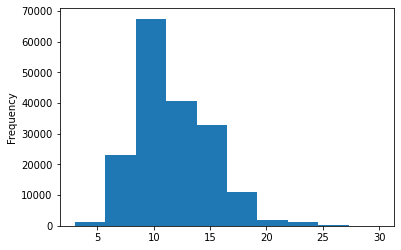

In [14]:
# Length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

In [17]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ('target' columns) and encode htem into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

Start with a baseline (TF-IDF Multinomial Naive Bayes Classifier)

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In previous projects, I wrote functions to compare predcitions across different metrics (accuracy, precision, recall, and f1)

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-15 13:49:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 13:49:37 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (text) for deep sequence models

Before I start building deeper models, I have to create vectorization and embedding layers.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

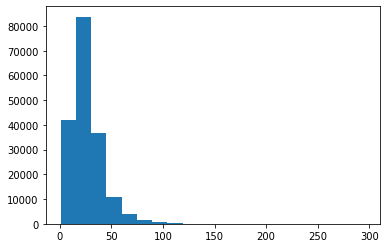

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [31]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
intensive gait training with rhythmic auditory stimulation resulted in significant improvement in scores on the berg balance scale , gait velocity , cadence , stride length and double support period in affected side , and stroke specific quality of life scale compared with the control group after training .

Length of text: 49

Vectorized text: [[  642  1222   155     7 10994  2727   465   568     5    37   194     5
    119    18     2  7580   900   158  1222  1462  8755  7774   523     3
   1380   279   173     5   804   493     3   276   628   141     4   195
    158    34     7     2    35    13    21   155     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # Use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

In [38]:
# Show an example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 intensive gait training with rhythmic auditory stimulation resulted in significant improvement in scores on the berg balance scale , gait velocity , cadence , stride length and double support period in affected side , and stroke specific quality of life scale compared with the control group after training .

Sentence after vectorization (before embedding):
 [[  642  1222   155     7 10994  2727   465   568     5    37   194     5
    119    18     2  7580   900   158  1222  1462  8755  7774   523     3
   1380   279   173     5   804   493     3   276   628   141     4   195
    158    34     7     2    35    13    21   155     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.03215375  0.03581188 -0.03707707 ...  0.00924815 -0.02729884
    0.04882158]
  [ 0.00878639 -0.02523999  0.04001763 ...  0.04324596 -0.016127
   -0.03887142]
  [ 0.02003874 -0.02078857 -0.0288848  ... -0.01786386  0.03917949
    0.0

## Creating datasets (making sure the data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [39]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings

In [41]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
# Fit the model
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9191 - accuracy: 0.6395 - val_loss: 0.6845 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6536 - accuracy: 0.7590 - val_loss: 0.6270 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6125 - accuracy: 0.7784 - val_loss: 0.5936 - val_accuracy: 0.7866


In [43]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5937 - accuracy: 0.7888


[0.5936817526817322, 0.7887594103813171]

In [44]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.8712647e-01, 1.5368707e-01, 5.6466620e-02, 2.7658442e-01,
         2.6135489e-02],
        [3.7974706e-01, 3.6163703e-01, 1.4948796e-02, 2.3146398e-01,
         1.2203149e-02],
        [1.2315707e-01, 5.5842404e-03, 1.5430005e-03, 8.6968488e-01,
         3.0741907e-05],
        ...,
        [1.3256995e-05, 8.2593039e-04, 8.9799101e-04, 4.2946494e-06,
         9.9825853e-01],
        [4.9015958e-02, 4.6933392e-01, 8.8776954e-02, 5.9830774e-02,
         3.3304235e-01],
        [1.4814983e-01, 7.1966839e-01, 4.5104973e-02, 5.1240794e-02,
         3.5836034e-02]], dtype=float32), (30212, 5))

In [45]:
# Conert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.87594333377466,
 'f1': 0.7862721271245597,
 'precision': 0.7858276875757771,
 'recall': 0.7887594333377466}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now, I'll use pretrained word embeddings from TensorFlow Hub, more specifically, the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentenceL\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentenceL
 seal success increased with total energy applied to the tissue , a higher maximum temperature , and longer coagulation as indicated by desiccation time .
Sentence after embedding:
[-0.0330913   0.02905063  0.025822    0.00126454 -0.03497555 -0.03915905
  0.03392848 -0.064411    0.07702156  0.07556724  0.0423783   0.04681624
 -0.00552787 -0.00714994  0.06807494 -0.00818633  0.02514997  0.00897149
  0.00087357  0.00591801 -0.06235357  0.06083597 -0.02255995  0.05321718
  0.06621464 -0.00737187 -0.08149143 -0.02245205 -0.08406492  0.00584092]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow HUB

In [50]:
# Define feature extraction model using Tf Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: only using 1 layer here for simplification
outputs = layers.Dense(num_classes, activation='softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [51]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 25ms/step - loss: 0.9180 - accuracy: 0.6495 - val_loss: 0.7978 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7701 - accuracy: 0.7016 - val_loss: 0.7562 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7546 - accuracy: 0.7121 - val_loss: 0.7407 - val_accuracy: 0.7128


In [52]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7431 - accuracy: 0.7137


[0.7430770993232727, 0.7137230038642883]

In [53]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3273172e-01, 3.7927893e-01, 2.4327035e-03, 1.7707144e-01,
        8.4851747e-03],
       [3.7804720e-01, 4.7150993e-01, 3.4922080e-03, 1.4418344e-01,
        2.7671400e-03],
       [2.3983258e-01, 1.5890402e-01, 1.6613606e-02, 5.4724634e-01,
        3.7403416e-02],
       ...,
       [1.4716876e-03, 4.1923979e-03, 4.7136962e-02, 5.6824333e-04,
        9.4663072e-01],
       [3.6254409e-03, 5.1321466e-02, 2.0612741e-01, 1.6089516e-03,
        7.3731667e-01],
       [1.4081955e-01, 2.8983423e-01, 5.0926739e-01, 5.5555319e-03,
        5.4523356e-02]], dtype=float32)

In [54]:
# Conver the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [55]:
# Calculate results from TF Hub pretrained embedding results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.37230239639878,
 'f1': 0.7106672775898618,
 'precision': 0.7141589761303244,
 'recall': 0.7137230239639878}

## Model 3: Conv1D with character embeddings

The paper whch I'm replicating states they used a combination of token and character-level embeddings.

Previously, we've token-level embeddings but similar steps need ot be taken for characters in order ot use char-level embeddings.

### Creating a character-level tokenizer

In [56]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [57]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

's e a l   s u c c e s s   i n c r e a s e d   w i t h   t o t a l   e n e r g y   a p p l i e d   t o   t h e   t i s s u e   ,   a   h i g h e r   m a x i m u m   t e m p e r a t u r e   ,   a n d   l o n g e r   c o a g u l a t i o n   a s   i n d i c a t e d   b y   d e s i c c a t i o n   t i m e   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [59]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

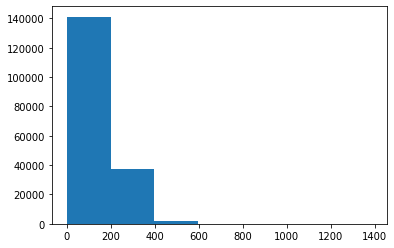

In [60]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [61]:
# Find the character length that covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None # set standardization to 'None' if you want to leave punctuation in
                                    name='char_vectorizer')


In [64]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Clarified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Clarified text:
 o n   @   s e p a r a t e   d a y s   ,   @   t r a i n e d   m a l e   c y c l i s t s   (   @   @   y   ,   @   @   k g   ,   p o w e r   o u t p u t   a t   m a x i m a l   a e r o b i c   p o w e r   - l s b -   p v o @ m a x   - r s b -   @   @   w   )   p e r f o r m e d   a   @ - m i n   m a x i m a l   c y c l i n g   b o u t   a t   @   %   p v o @ m a x   b e f o r e   a   @ - m i n   r a n d o m l y   a s s i g n e d   r e c o v e r y   i n t e r v e n t i o n   o f   p a s s i v e   (   p a s   :   r e s t i n g   )   ,   a c t i v e   (   a c t   :   @   %   p v o @ m a x   )   ,   o r   n m e s   (   @   h z   ,   @   p u l s e s   a t   @   s   )   .

Length of random_train_chars: 260

Vectorized chars:
 [[ 7  6  9  2 14  5  8  5  3  2 10  5 19  9  3  8  5  4  6  2 10 15  5 12
   2 11 19 11 12  4  9  3  9 19 23 18 14  7 20  2  8  7 16  3 14 16  3  5
   3 15  5 24  4 15  5 12  5  2  8  7 22  4 11 14  7 20  2  8 12  9 22 14
  21  7 15  5 24  8  9 22 20 14 

## Creating a character-level embedding

In [67]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of differenct characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name='char_embed')

In [68]:
# Test character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 o n   @   s e p a r a t e   d a y s   ,   @   t r a i n e d   m a l e   c y c l i s t s   (   @   @   y   ,   @   @   k g   ,   p o w e r   o u t p u t   a t   m a x i m a l   a e r o b i c   p o w e r   - l s b -   p v o @ m a x   - r s b -   @   @   w   )   p e r f o r m e d   a   @ - m i n   m a x i m a l   c y c l i n g   b o u t   a t   @   %   p v o @ m a x   b e f o r e   a   @ - m i n   r a n d o m l y   a s s i g n e d   r e c o v e r y   i n t e r v e n t i o n   o f   p a s s i v e   (   p a s   :   r e s t i n g   )   ,   a c t i v e   (   a c t   :   @   %   p v o @ m a x   )   ,   o r   n m e s   (   @   h z   ,   @   p u l s e s   a t   @   s   )   .

Embedded chars (after vectorization and embedding):
 [[[ 0.03411731 -0.01901652  0.01150987 ... -0.04855486  0.00118207
    0.03314878]
  [ 0.04991332 -0.04298117  0.03229178 ... -0.00879811  0.01431867
    0.03144664]
  [ 0.01591964 -0.03038229  0.02641264 ... -0.00262592 -0.04172095
    0.00508729]
  ...


### Building a Conv1D model to fit on character embeddings

In [69]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# Compile
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [70]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [71]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [72]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2537 - accuracy: 0.4976 - val_loss: 1.0563 - val_accuracy: 0.5791
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0208 - accuracy: 0.5906 - val_loss: 0.9524 - val_accuracy: 0.6277
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9384 - accuracy: 0.6325 - val_loss: 0.8637 - val_accuracy: 0.6679


In [73]:
# Make predictions with characte model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.25070596, 0.42740762, 0.09062542, 0.1655024 , 0.06575862],
       [0.30479264, 0.4451465 , 0.05006694, 0.14785253, 0.05214139],
       [0.15897958, 0.17931347, 0.11715131, 0.49684367, 0.04771206],
       ...,
       [0.03773348, 0.03165836, 0.07229465, 0.04358665, 0.8147269 ],
       [0.04453416, 0.14698961, 0.37371758, 0.04187077, 0.39288792],
       [0.41709077, 0.37805396, 0.1219451 , 0.07256996, 0.01034018]],
      dtype=float32)

In [74]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [75]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.56666225340923,
 'f1': 0.6445458029629688,
 'precision': 0.6473319573487595,
 'recall': 0.6556666225340924}